In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
import nltk
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import stopwords
from datetime import timedelta
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import LogisticRegressionCV as LogRegCV
import math
import string 
from six.moves.html_parser import HTMLParser
import urllib2
import json
import time
from functools import wraps
from copy import deepcopy
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import EnglishStemmer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
df = pd.read_excel('10_year_data.xlsx')
df['pub_date'] = pd.DatetimeIndex(df['pub_date']).normalize()
#df['pub_date'] = pd.to_datetime(df['pub_date']).normalize()
print 'Number of total articles:', df.shape[0]

Number of total articles: 655600


In [ ]:
""" data = pandas dataframe with columns 'pub_date', 'headline', 'paragraph'
    option = 'headline' or 'paragraph' (default = 'headline')
    date_filer = (start date, end date) inclusive; else if default = None, then no filter 
    word_filter = list of words to filter OPTION by (CASE SENSITIVE); default is None
    pos = list of parts of speech tags (default = None)
    stem = boolean, whether or not to stem (default = False)"""

def filter_data(data, option = 'headline', date_filter = None, word_filter = None):
    h = HTMLParser()
    
    # filter by dates
    if date_filter is not None:
        start_date, end_date = date_filter
        filtered_data = data[(data['publish_date'] >= start_date) & (data['publish_date'] <= end_date)]
    else:
        filtered_data = data
        
    
    # filter by words
    if word_filter is not None:
        idx_to_drop = [] # store indices of rows that do not contain filter words
        
        # for every article
        for i in range(filtered_data.shape[0]):
            text = filtered_data.iloc[i][option]
            
            # iterates through each filter word
            filter_flag = 0
            # if there is no text (type is not string)
            if isinstance(text, basestring) is False:
                idx_to_drop.append(i)
                continue
            for word in word_filter:
                if word in text:
                    filter_flag = 1
                    break
            # if no filter words in text, drop
            if filter_flag == 0:
                idx_to_drop.append(i)
    
    # drops rows without words in filter
    filtered_data = filtered_data.drop(filtered_data.index[idx_to_drop])
    
    # remove caps
    filtered_data[option] = filtered_data[option].str.lower()
    
    # remove punctuation
    # remove html encoding puncuation from old news
    html_encoding = ['&#8217;', '&#8212;', '&#038;', '&#8230;', '&#8220;', '&#8221;']
    for i in range(filtered_data.shape[0]):
        for encoding in html_encoding:
            if encoding in filtered_data.iloc[i][option]:
                index = filtered_data.index[i]
                filtered_data.loc[index, option] = filtered_data.loc[index, option].replace(encoding, h.unescape(encoding))
    
    # remove other punctuation
    punctuation = list(',.!@#$%^&*()\'\"`:;?' + u'\u2018' + u'\u2019')
    for c in punctuation:
        filtered_data[option] = filtered_data[option].str.replace(c, '')
    
#     # remove stop words
#     for i in range(filtered_data.shape[0]):
#         headline = filtered_data.iloc[i][option]
#         headline = headline.split()
#         new_headline = []
#         for word in headline:
#             if word not in stopwords.words('english'):
#                 new_headline += [word]
        
#         index = filtered_data.index[i]
#         filtered_data.loc[index, option] = ' '.join(new_headline)
                    
    return filtered_data

# makes bag of words given a pre-filtered DF and the option of using title or abstract
# def make_bag_of_words(df, option = 'headline'):
#     num_articles = df.shape[0]
#     words_lst = []
#     for i in range(num_articles):
#         words_lst += df.iloc[i][option].split()
    
#     unique_words = list(set(words_lst))
#     print '\nNumber of unique words across all text (including stopwords):', len(unique_words)
    
#     # new predictors
#     bag_words = np.zeros((df.shape[0], len(unique_words)))
    
#     # text of words is a list
#     for i in range(num_articles):
#         text = df.iloc[i][option].split()
#         for word in text:
#             word_col_num = unique_words.index(word)
#             bag_words[i, word_col_num] += 1
    
#     print unique_words[:20]
#     print bag_words[:5, :20]
    
#     return bag_words, unique_words

In [54]:
filtered_df = filter_data(df, word_filter = ['Apple', 'AAPL', 'iPhone', 'iPod', 'MacBook'], option = 'headline')
print 'Number of articles after filtering:', filtered_df.shape[0]

Number of articles after filtering: 1430


In [55]:
filtered_df.to_excel('10_year_filtered_data.xlsx')

# Import: start here

In [3]:
filtered_df = pd.read_excel('10_year_filtered_data.xlsx')

In [4]:
def filter_misc(series, pos = None, stem = False):
    new_series = pd.Series(index = series.index)
    
    if stem == True:
        # does not stem stopwords
        stemmer = EnglishStemmer(ignore_stopwords = True)
    
    
    if pos is not None:
        for index, text in enumerate(series):
            new_series.iloc[index] = ' '.join([y for y,tag in nltk.pos_tag(nltk.word_tokenize(text)) if tag in pos])
        pos_flag = True
    else:
        pos_flag = False
        
    if stem is True:
        # if both pos and stem
        if pos_flag == True:
            use_series = new_series
        # just stem
        else:
            use_series = series
        for index, text in enumerate(use_series):
            text_list = text.split()
            stemmed_text = []
            for word in text_list:
                stemmed_text += [stemmer.stem(word)]
            new_series.iloc[index] = ' '.join(stemmed_text)
            
    return new_series

In [5]:
filtered_df.head(n=5)

,headline,paragraph,pub_date
424,honoring rw apple in words and food,"About 1,000 of R.W. Apple’s admirers turned ou...",2006-12-06
802,if an ipod gets you through the day this can s...,The XtremeMac Luna is an iPod dock that double...,2006-12-07
1919,apple and its actresses,To the Editor: Re ''She Sings! She Acts! She P...,2006-12-10
2203,sales of ipods and itunes not much in sync,The numbers suggest that iPods are not driving...,2006-12-11
2434,a fund plans to offer a rival slate of directo...,"This is the first time the fund, Breeden Capit...",2006-12-12


In [6]:
filtered_df_pos = deepcopy(filtered_df)
filtered_df_stem = deepcopy(filtered_df)
filtered_df_pos_stem = deepcopy(filtered_df)

filtered_df_pos['headline'] = filter_misc(filtered_df_pos['headline'], pos = ['NN', 'JJ'], stem = False)
filtered_df_stem['headline'] = filter_misc(filtered_df_stem['headline'], pos = None, stem = True)
filtered_df_pos_stem['headline'] = filter_misc(filtered_df_pos_stem['headline'], pos = ['NN', 'JJ'], stem = True)

In [7]:
filtered_df_pos.head()

,headline,paragraph,pub_date
424,rw apple food,"About 1,000 of R.W. Apple’s admirers turned ou...",2006-12-06
802,ipod day,The XtremeMac Luna is an iPod dock that double...,2006-12-07
1919,apple,To the Editor: Re ''She Sings! She Acts! She P...,2006-12-10
2203,sync,The numbers suggest that iPods are not driving...,2006-12-11
2434,fund rival slate chain,"This is the first time the fund, Breeden Capit...",2006-12-12


In [8]:
filtered_df_pos_stem.head()

,headline,paragraph,pub_date
424,rw appl food,"About 1,000 of R.W. Apple’s admirers turned ou...",2006-12-06
802,ipod day,The XtremeMac Luna is an iPod dock that double...,2006-12-07
1919,appl,To the Editor: Re ''She Sings! She Acts! She P...,2006-12-10
2203,sync,The numbers suggest that iPods are not driving...,2006-12-11
2434,fund rival slate chain,"This is the first time the fund, Breeden Capit...",2006-12-12


In [9]:
filtered_df_stem.head()

,headline,paragraph,pub_date
424,honor rw appl in word and food,"About 1,000 of R.W. Apple’s admirers turned ou...",2006-12-06
802,if an ipod get you through the day this can st...,The XtremeMac Luna is an iPod dock that double...,2006-12-07
1919,appl and its actress,To the Editor: Re ''She Sings! She Acts! She P...,2006-12-10
2203,sale of ipod and itun not much in sync,The numbers suggest that iPods are not driving...,2006-12-11
2434,a fund plan to offer a rival slate of director...,"This is the first time the fund, Breeden Capit...",2006-12-12


In [10]:
# threshold_low is the minimum amount of count a word must have to be included (inclusive)
# threshold_high is the maximum count a word may have and still be included (inclusive)
def vectorize(series, threshold_low = 0, threshold_high = None):
    if threshold_high is not None:
        vectorizer = CountVectorizer(stop_words = 'english', min_df = threshold_low + 1, max_df = threshold_high)
    else:
        vectorizer = CountVectorizer(stop_words = 'english', min_df = threshold_low + 1)
        
    vectorized = vectorizer.fit_transform(series).toarray()
    feat_names = vectorizer.get_feature_names()
    
    return vectorized, feat_names

In [11]:
vectorized_1gram, vectorized_1gram_names = vectorize(filtered_df['headline'])
vectorized_pos_1gram, vectorized_pos_1gram_names = vectorize(filtered_df_pos['headline'])
vectorized_stem_1gram, vectorized_stem_1gram_names = vectorize(filtered_df_stem['headline'])
vectorized_pos_stem_1gram, vectorized_pos_stem_1gram_names = vectorize(filtered_df_pos_stem['headline'])

In [12]:
print 'Number of predictors:'
print 'Original (no pos and no stem):', vectorized_1gram.shape[1]
print 'Pos only:', vectorized_pos_1gram.shape[1]
print 'Stem only:', vectorized_stem_1gram.shape[1]
print 'Both pos and stem:', vectorized_pos_stem_1gram.shape[1]

Number of predictors:
Original (no pos and no stem): 2960
Pos only: 1685
Stem only: 2392
Both pos and stem: 1620


In [13]:
# Number of Top words to Look At
num_top_words = 50
bag_to_use = vectorized_pos_stem_1gram
feature_names_to_use = vectorized_pos_stem_1gram_names

# Count the number of time each word occurs in the entire dataset
word_freq = bag_to_use.sum(axis=0)
print word_freq.shape

words = zip(word_freq, feature_names_to_use)
top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:num_top_words]

print top_words

(1620L,)
[(769, u'appl'), (353, u'iphon'), (78, u'new'), (60, u'ipod'), (51, u'app'), (42, u'case'), (41, u'music'), (36, u'big'), (35, u'china'), (30, u'samsung'), (29, u'googl'), (27, u'watch'), (25, u'patent'), (19, u'apple'), (19, u'chief'), (19, u'profit'), (18, u'tax'), (18, u'tv'), (16, u'fbi'), (16, u'servic'), (16, u'softwar'), (16, u'week'), (15, u'att'), (15, u'book'), (15, u'ipad'), (15, u'mobil'), (15, u'video'), (14, u'deal'), (13, u'donald'), (13, u'fight'), (13, u'market'), (13, u'microsoft'), (13, u'pay'), (13, u'store'), (13, u'trump'), (12, u'price'), (12, u'tech'), (11, u'court'), (11, u'day'), (11, u'disput'), (11, u'execut'), (11, u'macbook'), (11, u'phone'), (11, u'privaci'), (11, u'quarter'), (11, u'record'), (11, u'review'), (11, u'rival'), (10, u'cook'), (10, u'use')]


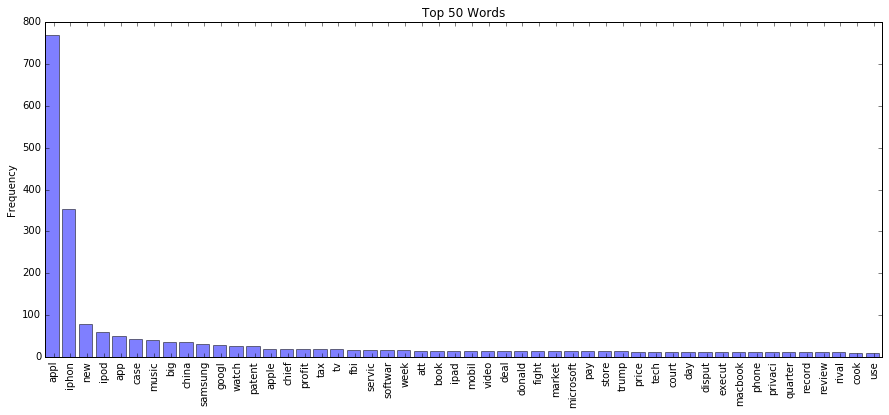

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

#Number of bars to use
indices = np.arange(num_top_words)
#Where to put the label under each bar
width = 0.5
#Bar plot of the frequencies of the top words
ax.bar(indices, [word[0] for word in top_words], color='blue', alpha=0.5)

ax.set_ylabel('Frequency')
ax.set_title('Top ' + str(num_top_words) + ' Words')

#Label the bars with the top words
ax.set_xticks(indices + width)
ax.set_xticklabels([word[1] for word in top_words])

#Turn the labels sideways so they don't overlap
labels = ax.get_xticklabels()
plt.setp(labels, rotation=90, fontsize=10)

plt.show()

In [15]:
# load stock price
stock_price = pd.read_csv('12-4-06-to-12-3-16-Quotes.csv', parse_dates = [0], keep_date_col = True, encoding = 'cp1252')
stock_price.head(n=5)

,date,close,volume,open,high,low
0,2016-12-02,109.90,26481320.0,109.170,110.090,108.85
1,2016-12-01,109.49,37034520.0,110.365,110.940,109.03
2,2016-11-30,110.52,36151450.0,111.600,112.200,110.27
3,2016-11-29,111.46,28507780.0,110.780,112.030,110.07
4,2016-11-28,111.57,27054320.0,111.430,112.465,111.39


In [16]:
""" Function returns the nearest date closest to the given date
        stock_df: a dataframe
        date: a date in date format 
        time_type: "before" or "after"
            "before": finds the nearest business day before the given date
            "after": finds the nearest business day after the given date """
def find_nearest_biz_day(stock_df, date, time_type, counter = 0):
    if counter > 10:
        return None
    price = stock_df[stock_df['date'] == date]['close'].values
    if time_type == 'after':
        # if date exists (i.e., not weekend or holiday)
        if price.size != 0:
            return date
        # if weekend or holiday
        else:
            new_date = date + timedelta(days = 1)
            counter += 1
            return find_nearest_biz_day(stock_df, date + timedelta(days = 1), 'after', counter)
    elif time_type == 'before' or time_type == 'before and done':
        day_before_price = stock_df[stock_df['date'] == date - timedelta(days = 1)]['close'].values
        # if date exists (i.e., not weekend or holiday)
        if price.size != 0 and day_before_price != 0 and time_type == 'before':
            return date - timedelta(days = 1)
        elif price.size != 0 and time_type == 'before and done':
            return date
        # if weekend or holiday
        else:
            counter+= 1
            return find_nearest_biz_day(stock_df, date - timedelta(days = 1), 'before and done', counter)

# Below is Cell X with the threshold
#### (Referenced in the RF section)

In [17]:
results = []
before_p = []
after_p = []
price_list = []

# iterate through news article's weekday along with corresponding published date
for date in filtered_df['pub_date']:
    compare_date_after = find_nearest_biz_day(stock_price, date, 'after')
    compare_date_before = find_nearest_biz_day(stock_price, date, 'before')
    if compare_date_after is None:
        print 'No after:', date
    if compare_date_before is None:
        print 'No before:', date
    price_after = stock_price[stock_price['date'] == compare_date_after]['close'].values
    price_before = stock_price[stock_price['date'] == compare_date_before]['close'].values
    
    # stock price the day after is higher than stock price day before, encode binary 1
    price_diff = price_after[0] - price_before[0]
    threshold = 0.005 * -1*price_before[0]
    if price_diff <= threshold:
        results += [0]
    # no increase or decrease in stock price, encode binary 0
    else:
        results += [1]
        
    # true before and after values
    before_p += [price_before[0]]
    after_p += [price_after[0]]

filtered_df['price_before'] = before_p
filtered_df['price_after'] = after_p
filtered_df['price_diff'] = filtered_df['price_after'] - filtered_df['price_before']
filtered_df['y'] = results

In [18]:
filtered_df

,headline,paragraph,pub_date,price_before,price_after,price_diff,y
424,honoring rw apple in words and food,"About 1,000 of R.W. Apple’s admirers turned ou...",2006-12-06,13.0386,12.8329,-0.2057,0
802,if an ipod gets you through the day this can s...,The XtremeMac Luna is an iPod dock that double...,2006-12-07,12.8329,12.4343,-0.3986,0
1919,apple and its actresses,To the Editor: Re ''She Sings! She Acts! She P...,2006-12-10,12.6086,12.6786,0.0700,1
2203,sales of ipods and itunes not much in sync,The numbers suggest that iPods are not driving...,2006-12-11,12.6086,12.6786,0.0700,1
2434,a fund plans to offer a rival slate of directo...,"This is the first time the fund, Breeden Capit...",2006-12-12,12.6786,12.3057,-0.3729,0
5354,a simple add-on keeps an ipod hanging around,This tiny piece of plastic connects to the syn...,2006-12-21,12.1086,11.8429,-0.2657,0
7260,apple shares buffeted by report on options inq...,Investors discounted the possibility that Appl...,2006-12-28,11.6457,11.5529,-0.0928,0
7286,the iphone really exists but apple doesnt make it,"Cisco Systems, not Apple, owns the iPhone trad...",2006-12-28,11.6457,11.5529,-0.0928,0
7488,apple says options probe exonerates executives,"Apple said that its chief executive, Steven P....",2006-12-29,11.5529,12.1200,0.5671,1
7545,apple filing to tell all on options,Apple is likely to answer questions about back...,2006-12-29,11.5529,12.1200,0.5671,1


# PCA

In [73]:
def make_pca(bag_to_use, pca_components):
    pca = PCA(n_components = pca_components)
    pca.fit(bag_to_use)
    return pca.transform(bag_to_use)

In [87]:
# project to the data onto the two axes
bag_words_pca_1gram = make_pca(vectorized_1gram, 2)
bag_words_pca_pos_1gram = make_pca(vectorized_pos_1gram, 2)
bag_words_pca_stem_1gram = make_pca(vectorized_stem_1gram, 2)
bag_words_pca_pos_stem_1gram = make_pca(vectorized_pos_stem_1gram, 2)

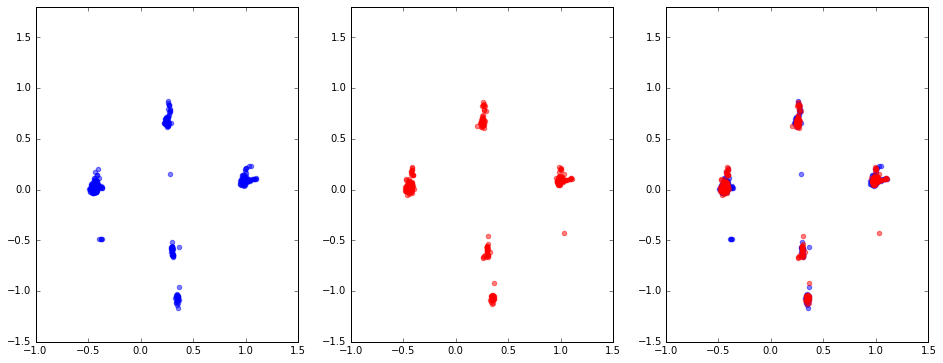

In [138]:
bag_to_use = bag_words_pca_stem_1gram
y = filtered_df['y'].values

fig, ax = plt.subplots(1, 3, figsize = (16, 6))
ax[0].scatter(bag_to_use[y == 0, 0], bag_to_use[y == 0, 1], color = 'b', alpha = 0.5, label = 'No change/decrease')
ax[1].scatter(bag_to_use[y == 1, 0], bag_to_use[y == 1, 1], color = 'r', alpha = 0.5, label = 'Increase')
ax[2].scatter(bag_to_use[y == 0, 0], bag_to_use[y == 0, 1], color = 'b', alpha = 0.5, label = 'No change/decrease')
ax[2].scatter(bag_to_use[y == 1, 0], bag_to_use[y == 1, 1], color = 'r', alpha = 0.5, label = 'Increase')
for axis in ax:
    axis.set_xlim([-1, 1.5])
    axis.set_ylim([-1.5, 1.8])

# Classification: RF

In [108]:
""" Function that computes the accuracy a given model on the entire test set, 
    the accuracy on class 0 in the test set
    and the accuracy on class 1 in the test set. 
    Returns a pandas Series """
def score(model, x_test, y_test): 
    accuracy_overall = model.score(x_test, y_test)
    accuracy_class0 = model.score(x_test[y_test == 0], y_test[y_test == 0])
    accuracy_class1 = model.score(x_test[y_test == 1], y_test[y_test == 1])
    return pd.Series([accuracy_overall, accuracy_class0, accuracy_class1],
                     index=['Overall accuracy', 'Accuracy on class 0', 'Accuracy on class 1'])

In [111]:
# classification
bag_to_use = bag_words_pca_stem_1gram
y = filtered_df['y'].values

x_train, x_test, y_train, y_test = train_test_split(bag_to_use, 
                                                    y, 
                                                    test_size = 0.4, 
                                                    random_state = 42)

ones_train = y_train[y_train == 1].shape[0]
zeros_train = y_train[y_train == 0].shape[0]
# twos_train = y_train[y_train == 2].shape[0]

zeros_test = y_test[y_test == 0].shape[0]
ones_test = y_test[y_test == 1].shape[0]
# twos_test = y_test[y_test == 2].shape[0]

# print 'Twos Count - Train: ', twos_train
print 'Ones Count - Train: ', ones_train
print 'Zeros Count - Train: ', zeros_train
# print 'Twos Count - Test: ', twos_train
print 'Ones Count - Test: ', ones_test
print 'Zeros Count - Test: ', zeros_test

y_pos = np.zeros(x_test.shape[0]) + 1
y_neg = np.zeros(x_test.shape[0])
print 'Negative baseline:', float(zeros_test)/(ones_test + zeros_test)
print 'Positive baseline:', float(ones_test)/(ones_test + zeros_test)

Ones Count - Train:  354
Zeros Count - Train:  504
Ones Count - Test:  238
Zeros Count - Test:  334
Negative baseline: 0.583916083916
Positive baseline: 0.416083916084


In [113]:
rf = RandomForest(max_depth = 9, max_leaf_nodes = 5, class_weight = 'balanced')
rf.fit(x_train, y_train)
rf_score = rf.score(x_test, y_test)
rf_score_train = rf.score(x_train, y_train)

print 'Test score:\n', score(rf, x_test, np.array(y_test))
print 'Train score:\n', score(rf, x_train, np.array(y_train))

Test score:
Overall accuracy       0.536713
Accuracy on class 0    0.619760
Accuracy on class 1    0.420168
dtype: float64
Train score:
Overall accuracy       0.603730
Accuracy on class 0    0.684524
Accuracy on class 1    0.488701
dtype: float64


In [114]:
### RF CV

# parameters for tuning
n_trees = np.arange(10, 200, 20) 
depths = np.arange(2, 10)
leaf_nodes = np.arange(2, 10)
num_folds = 4

# to keep track of the best model
best_avg = 0
best_pos = 0

best_pos_score = 0
# iterate through trees and depths
for nodes in leaf_nodes:
    for trees in n_trees:
        for depth in depths:
            # cross validation for every experiment
            k_folds = KFold(x_train.shape[0], n_folds = num_folds, shuffle = True)
            scores = []

            # for each fold
            for train_indices, validation_indices in k_folds:
                # generate training data
                x_train_cv = x_train[train_indices]
                y_train_cv = y_train[train_indices]
                # generate validation data
                x_validate = x_train[validation_indices]
                y_validate = y_train[validation_indices]

                # fit random forest on training data
                rf = RandomForest(n_estimators = trees, max_depth = depth, max_leaf_nodes = nodes, class_weight = 'balanced')
                rf.fit(x_train_cv, y_train_cv)

                # score on validation data
                scores += [score(rf, x_validate, np.array(y_validate)).values]

            # record and report accuracy
            average_score = np.mean(scores, axis = 0)

            # update our record of the best parameters see so far
            if np.mean(average_score) >= best_avg:
                print "[BEST AVG] Trees:", trees, "Depth:", depth, "Leaf nodes:", nodes, "Score:", average_score
                best_avg = np.mean(average_score)
#                 best_pos = average_score[2]
                best_overall_acc = average_score[0]
                best_class0_acc = average_score[1]
                best_class1_acc = average_score[2]
                best_trees = trees
                best_depth = depth
                best_nodes = nodes
            if average_score[2] >= best_pos:
                print "[BEST POS] Trees:", trees, "Depth:", depth, "Leaf nodes:", nodes, "Score:", average_score
                best_pos = average_score[2]

[BEST AVG] Trees: 10 Depth: 2 Leaf nodes: 2 Score: [ 0.56762117  0.78394702  0.26295634]
[BEST POS] Trees: 10 Depth: 2 Leaf nodes: 2 Score: [ 0.56762117  0.78394702  0.26295634]
[BEST POS] Trees: 10 Depth: 3 Leaf nodes: 2 Score: [ 0.54778309  0.69589779  0.33759652]
[BEST POS] Trees: 10 Depth: 5 Leaf nodes: 2 Score: [ 0.53609541  0.6528131   0.36726527]
[BEST POS] Trees: 10 Depth: 6 Leaf nodes: 2 Score: [ 0.53027603  0.62294271  0.3979387 ]
[BEST POS] Trees: 30 Depth: 2 Leaf nodes: 2 Score: [ 0.53372636  0.61701406  0.41908326]
[BEST POS] Trees: 30 Depth: 3 Leaf nodes: 2 Score: [ 0.52210932  0.57935216  0.43386876]
[BEST POS] Trees: 30 Depth: 6 Leaf nodes: 2 Score: [ 0.54665834  0.6032839   0.45955704]
[BEST AVG] Trees: 30 Depth: 8 Leaf nodes: 2 Score: [ 0.56058466  0.65941529  0.41569475]
[BEST AVG] Trees: 130 Depth: 4 Leaf nodes: 2 Score: [ 0.56408933  0.69052709  0.38454218]


KeyboardInterrupt: 